In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def load_gdrive_csv(view_url):
    file_id = view_url.split('/')[-2]
    url = f'https://drive.google.com/uc?id={file_id}'
    return pd.read_csv(url, on_bad_lines='skip')

train_df = load_gdrive_csv(
    'https://drive.google.com/file/d/1UlnpfTD-53TzUvDqmFMfN03hUXtGquFr/view?usp=drive_link')
test_df = load_gdrive_csv(
    'https://drive.google.com/file/d/1FMeGjhigcHdtBmIclxEDUaiBRUuf5H9_/view?usp=drive_link')


In [3]:
# Lấy 5 features: Price, Open, High, Low, Change %
features = ['Price', 'Open', 'High', 'Low', 'Change %']

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

In [4]:
# Hàm tạo chuỗi thời gian với window_size
window_size = 60
forecast_horizon = 30

# Hàm tạo sequence Many-to-One: X = 60 bước, y = Price bước tiếp theo
def create_sequences_mto(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # Price tại bước kế tiếp
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_mto(train_scaled, window_size)
X_test, y_test = create_sequences_mto(test_scaled, window_size)

print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape X_train: (3104, 60, 5), y_train: (3104,)
Shape X_test: (732, 60, 5), y_test: (732,)


In [5]:
# --------- Build model Many-to-One GRU --------------
def build_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [6]:
# Chia 10% dữ liệu train làm validation
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

param_grid = {
    'units': [32, 64],
    'learning_rate': [0.001, 0.005],
    'dropout_rate': [0.1, 0.2],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid = list(ParameterGrid(param_grid))

best_val_loss = float('inf')
best_params = None
best_model = None

input_shape = (X_train.shape[1], X_train.shape[2])

for i, params in enumerate(grid):
    print(f"\nRunning combination {i+1}/{len(grid)}: {params}")

    # Xây dựng model GRU Many-to-One với Dropout
    model = build_model(
        input_shape=input_shape,
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    # Biên dịch model với Adam optimizer và learning rate tùy chọn
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    # Early stopping để tránh overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Huấn luyện model
    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Lấy giá trị loss nhỏ nhất trên validation để đánh giá
    val_loss = min(history.history['val_loss'])
    print(f"Validation loss: {val_loss:.6f}")

    # Lưu lại model tốt nhất
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print("\nBest hyperparameters found:")
print(best_params)
print(f"With validation loss: {best_val_loss:.6f}")



Running combination 1/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.000136

Running combination 2/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}
Validation loss: 0.000132

Running combination 3/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.005, 'units': 32}
Validation loss: 0.000111

Running combination 4/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.005, 'units': 64}
Validation loss: 0.000111

Running combination 5/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.001, 'units': 32}
Validation loss: 0.000112

Running combination 6/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.001, 'units': 64}
Validation loss: 0.000121

Running combination 7/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.005, 'units': 32}
Validation loss: 0.000114

Running combination 8/32: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.005, '

In [7]:
# --- Fit scaler cho dữ liệu gốc ---
scaler_price = MinMaxScaler()
scaler_price.fit(train_df[['Price']])

# --- Nối window_size bước cuối của train với test ---
combined_test_input = np.vstack([train_scaled[-window_size:], test_scaled])

# --- Tạo lại X_test_full và y_test_full ---
X_test_full, y_test_full = create_sequences_mto(combined_test_input, window_size)

# --- Dự báo trên tập test đầy đủ ---
y_test_pred_scaled_full = best_model.predict(X_test_full).flatten()
y_test_pred_inv_full = scaler_price.inverse_transform(y_test_pred_scaled_full.reshape(-1, 1)).flatten()   # giá trị dự đoán
y_test_inv_full = scaler_price.inverse_transform(y_test_full.reshape(-1, 1)).flatten()                    # giá trị thực tế

# --- Tính toán đánh giá ---
mse = mean_squared_error(y_test_inv_full, y_test_pred_inv_full)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv_full, y_test_pred_inv_full)
mape = np.mean(np.abs((y_test_inv_full - y_test_pred_inv_full) / (y_test_inv_full + 1e-10))) * 100
r2 = r2_score(y_test_inv_full, y_test_pred_inv_full)

print(f"\n[Full Test Evaluation]")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

[Full Test Evaluation]
MSE: 0.0000
RMSE: 0.0055
MAE: 0.0039
MAPE: 0.48%
R2 Score: 0.9677


In [8]:
# --- Hàm autoregressive dự báo tương lai ---
def forecast_future(model, data_last_window, forecast_horizon):
    forecast = []
    current_input = data_last_window.copy()

    for _ in range(forecast_horizon):
        pred = model.predict(current_input[np.newaxis, :, :])[0, 0]
        forecast.append(pred)

        new_step = current_input[-1].copy()
        new_step[0] = pred  # cập nhật giá mới
        current_input = np.vstack([current_input[1:], new_step])

    return np.array(forecast)

In [9]:
# --- Dự báo 30 ngày ---
forecast_horizon = 30
last_window = test_scaled[-window_size:]
forecast_scaled = forecast_future(best_model, last_window, forecast_horizon)
forecast_30days_gru = scaler_price.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [10]:
print("Scaled forecast values:", forecast_scaled)
print("Inverse forecast values:", forecast_30days_gru)

Scaled forecast values: [0.730984   0.7323533  0.7332005  0.73369557 0.7339356  0.734018
 0.73402035 0.7339913  0.7339572  0.7339285  0.7339081  0.7338952
 0.73388755 0.7338833  0.7338814  0.73388064 0.73388034 0.7338802
 0.7338802  0.7338803  0.73388016 0.7338802  0.7338803  0.7338802
 0.7338802  0.7338803  0.7338802  0.7338802  0.7338802  0.7338802 ]
Inverse forecast values: [0.7929772  0.79337126 0.79361504 0.79375756 0.7938267  0.79385036
 0.793851   0.7938427  0.79383284 0.7938246  0.7938187  0.793815
 0.7938128  0.79381156 0.793811   0.79381084 0.7938108  0.79381067
 0.79381067 0.7938108  0.79381067 0.79381067 0.7938108  0.79381067
 0.79381067 0.7938108  0.79381067 0.79381067 0.79381067 0.79381067]


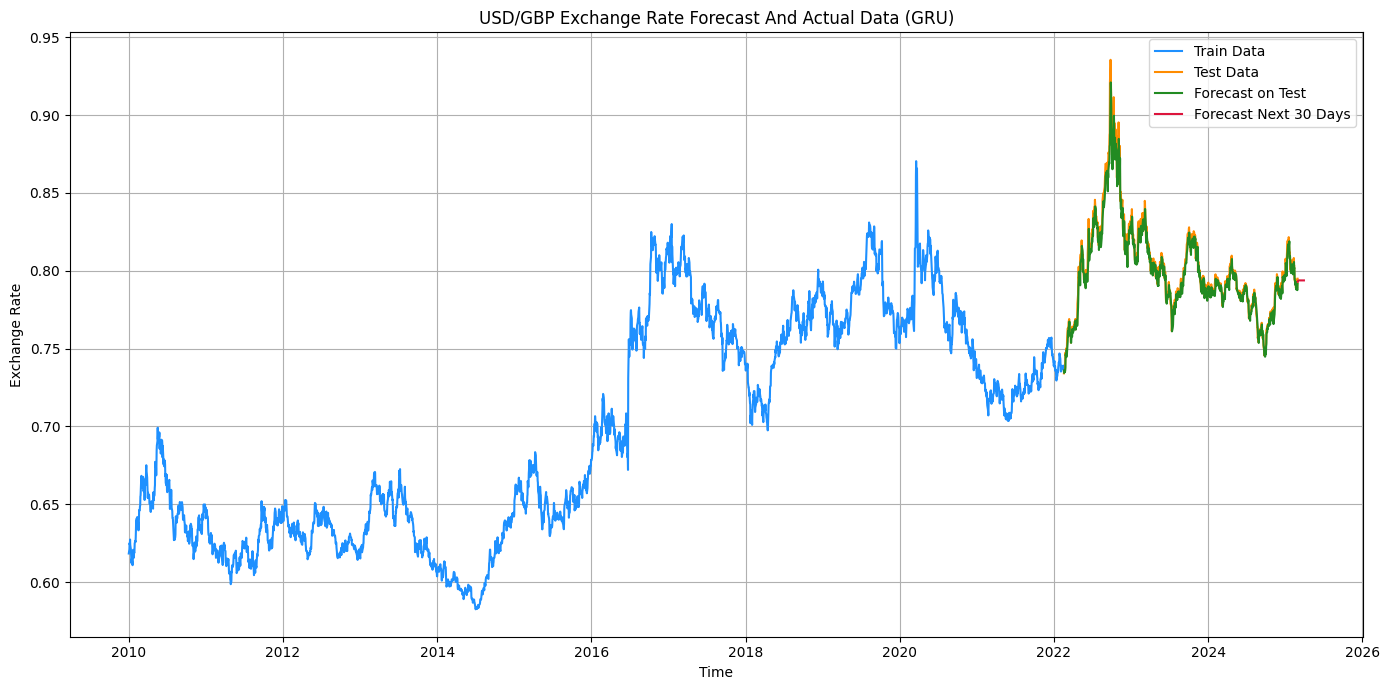

In [11]:
# --- Tạo mốc thời gian cho 30 ngày tới ---
last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# --- Vẽ biểu đồ kết quả ---
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['Price'], label='Train Data', color='dodgerblue')
plt.plot(test_df.index, test_df['Price'], label='Test Data', color='darkorange')
plt.plot(test_df.index[-len(y_test_pred_inv_full):], y_test_pred_inv_full, label='Forecast on Test', color='forestgreen')
plt.plot(future_dates, forecast_30days_gru, label='Forecast Next 30 Days', color='crimson')

plt.title('USD/GBP Exchange Rate Forecast And Actual Data (GRU)')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


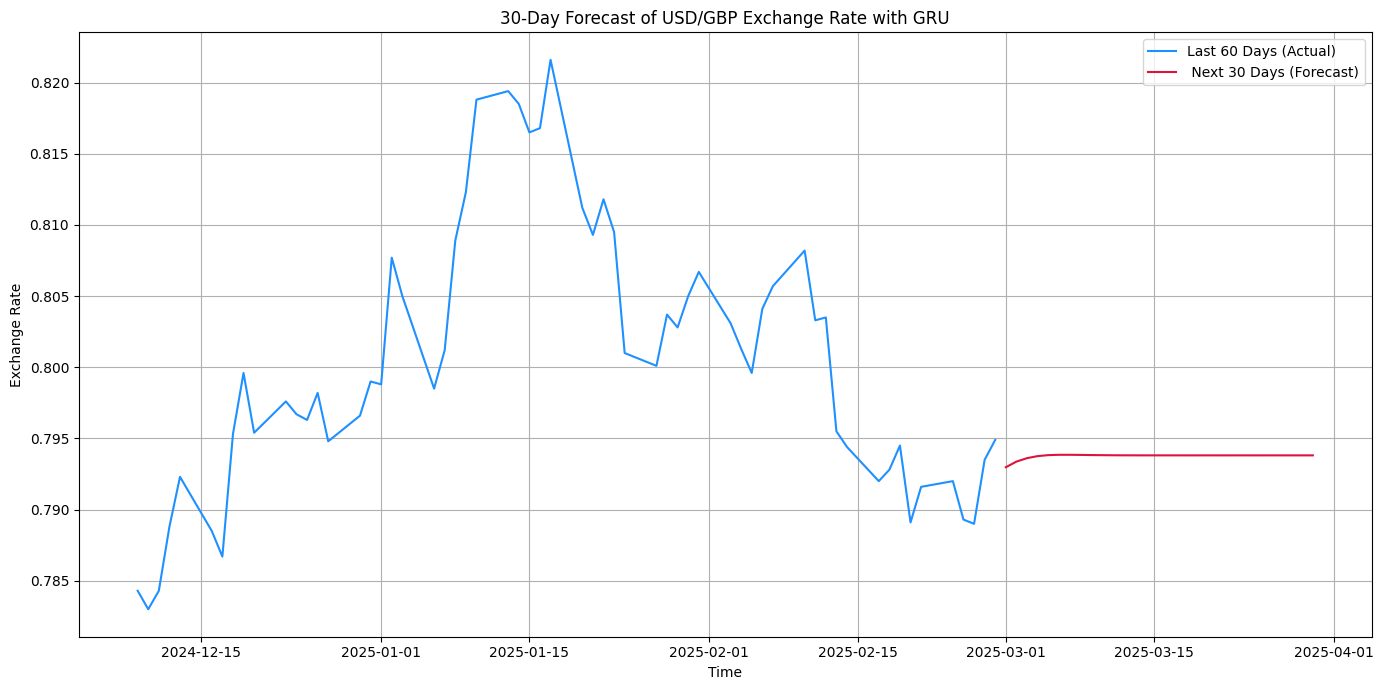

In [12]:
last_60_actual = test_df['Price'].values[-60:]
last_60_dates = test_df.index[-60:]

# --- Vẽ biểu đồ ---
plt.figure(figsize=(14, 7))
plt.plot(last_60_dates, last_60_actual, label=f'Last {window_size} Days (Actual)', color='dodgerblue')
plt.plot(future_dates, forecast_30days_gru, label=' Next 30 Days (Forecast)', color='crimson')

plt.title('30-Day Forecast of USD/GBP Exchange Rate with GRU')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()